# Clasificación de Piso en el Dataset UJIIndoorLoc usando Redes Neuronales Artificiales (ANN)

---

## Introducción

En este notebook se replica el flujo de análisis implementado previamente para la clasificación del **piso** en un entorno interior utilizando el dataset **UJIIndoorLoc**, pero en esta ocasión aplicando un modelo de **red neuronal artificial** con capas completamente conectadas (Fully Connected – FC).

El conjunto de datos UJIIndoorLoc contiene mediciones de señales WiFi tomadas en diferentes ubicaciones dentro de un edificio, junto con información asociada como coordenadas, piso, usuario y timestamp. Nuestro objetivo sigue siendo predecir el **piso** en el que se encuentra un dispositivo, tratando el problema como una clasificación multiclase (planta baja, primer piso, segundo piso, etc.).

## Objetivos

- **Cargar y explorar** el conjunto de datos UJIIndoorLoc.
- **Preparar** los datos seleccionando las características relevantes y la variable objetivo (`FLOOR`).
- **Dividir** el dataset en entrenamiento y validación (80/20).
- **Construir** una red neuronal totalmente conectada (fully connected ANN) para clasificar el piso.
- **Diseñar y ajustar** la arquitectura de la red (número de capas, unidades por capa, funciones de activación, etc.).
- **Evaluar el desempeño** del modelo en el conjunto de validación mediante métricas como *accuracy*, *precision*, *recall*, y *F1-score*.
- **Comparar los resultados** obtenidos con los modelos clásicos de clasificación entrenados anteriormente.

Este ejercicio permite evaluar la capacidad de generalización de una red neuronal densa sobre datos del mundo real, comparando su desempeño con algoritmos tradicionales y practicando buenas prácticas en diseño, entrenamiento y evaluación de modelos neuronales.

---


## Descripción del Dataset

El dataset utilizado en este análisis es el **UJIIndoorLoc Dataset**, ampliamente utilizado para tareas de localización en interiores a partir de señales WiFi. Está disponible públicamente en la UCI Machine Learning Repository y ha sido recopilado en un entorno real de un edificio universitario.

Cada muestra corresponde a una observación realizada por un dispositivo móvil, donde se registran las intensidades de señal (RSSI) de más de 500 puntos de acceso WiFi disponibles en el entorno. Además, cada fila contiene información contextual como la ubicación real del dispositivo (coordenadas X e Y), el piso, el edificio, el identificador del usuario, y la marca temporal.

El objetivo en esta tarea es predecir el **piso** (`FLOOR`) en el que se encontraba el dispositivo en el momento de la medición, considerando únicamente las características numéricas provenientes de las señales WiFi.

### Estructura del dataset

- **Número de muestras**: ~20,000
- **Número de características**: 520
  - 520 columnas con valores de intensidad de señal WiFi (`WAP001` a `WAP520`)
- **Variable objetivo**: `FLOOR` (variable categórica con múltiples clases, usualmente entre 0 y 4)

### Columnas relevantes

- `WAP001`, `WAP002`, ..., `WAP520`: niveles de señal recibida desde cada punto de acceso WiFi (valores entre -104 y 0, o 100 si no se detectó).
- `FLOOR`: clase objetivo a predecir (nivel del edificio).
- (Otras columnas como `BUILDINGID`, `SPACEID`, `USERID`, `TIMESTAMP`, etc., pueden ser ignoradas o utilizadas en análisis complementarios).

### Contexto del problema

La localización en interiores es un problema complejo en el que tecnologías como el GPS no funcionan adecuadamente. Los sistemas basados en WiFi han demostrado ser una alternativa efectiva para estimar la ubicación de usuarios en edificios. Poder predecir automáticamente el piso en el que se encuentra una persona puede mejorar aplicaciones de navegación en interiores, accesibilidad, gestión de emergencias y servicios personalizados. Este tipo de problemas es típicamente abordado mediante algoritmos de clasificación multiclase.


### Estrategia de evaluación

En este análisis seguiremos una metodología rigurosa para garantizar la validez de los resultados:

1. **Dataset de entrenamiento**: Se utilizará exclusivamente para el desarrollo, entrenamiento y optimización de hiperparámetros de todos los modelos. Este conjunto será dividido internamente en subconjuntos de entrenamiento y validación (80/20) para la selección de hiperparámetros mediante validación cruzada.

2. **Dataset de prueba**: Se reservará únicamente para la **evaluación final** de los modelos ya optimizados. Este conjunto **no debe ser utilizado** durante el proceso de selección de hiperparámetros, ajuste de modelos o toma de decisiones sobre la arquitectura, ya que esto introduciría sesgo y comprometería la capacidad de generalización estimada.

3. **Validación cruzada**: Para la optimización de hiperparámetros se empleará validación cruzada 5-fold sobre el conjunto de entrenamiento, lo que permitirá una estimación robusta del rendimiento sin contaminar los datos de prueba.

Esta separación estricta entre datos de desarrollo y evaluación final es fundamental para obtener una estimación realista del rendimiento que los modelos tendrían en un escenario de producción con datos completamente nuevos.

---


## Paso 1: Cargar y explorar el dataset

**Instrucciones:**
- Descarga el dataset **UJIIndoorLoc** desde la UCI Machine Learning Repository o utiliza la versión proporcionada en el repositorio del curso (por ejemplo: `datasets\UJIIndoorLoc\trainingData.csv`).
- Carga el dataset utilizando `pandas`.
- Muestra las primeras filas del dataset utilizando `df.head()`.
- Imprime el número total de muestras (filas) y características (columnas).
- Verifica cuántas clases distintas hay en la variable objetivo `FLOOR` y cuántas muestras tiene cada clase (`df['FLOOR'].value_counts()`).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir la ruta del archivo
file_path = 'dataset/UJIIndoorLoc/trainingData.csv'

# Cargar el dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {file_path}. Verifica la ruta.")

# Mostrar las primeras filas
display(df.head())

# Imprimir dimensiones
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de muestras: {df.shape[0]}")
print(f"Número de características: {df.shape[1]}")

# Verificar clases en FLOOR
print("\nConteo de muestras por piso (FLOOR):")
print(df['FLOOR'].value_counts().sort_index())

Dataset cargado correctamente.


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


Dimensiones del dataset: (19937, 529)
Número de muestras: 19937
Número de características: 529

Conteo de muestras por piso (FLOOR):
FLOOR
0    4369
1    5002
2    4416
3    5048
4    1102
Name: count, dtype: int64


---

## Paso 2: Preparar los datos

**Instrucciones:**

- Elimina las columnas que no son relevantes para la tarea de clasificación del piso:
  - `LONGITUDE`, `LATITUDE`, `SPACEID`, `RELATIVEPOSITION`, `USERID`, `PHONEID`, `TIMESTAMP`
- Conserva únicamente:
  - Las columnas `WAP001` a `WAP520` como características (RSSI de puntos de acceso WiFi).
  - La columna `FLOOR` como variable objetivo.
- Verifica si existen valores atípicos o valores inválidos en las señales WiFi (por ejemplo: valores constantes como 100 o -110 que suelen indicar ausencia de señal).
- Separa el conjunto de datos en:
  - `X`: matriz de características (todas las columnas `WAP`)
  - `y`: vector objetivo (`FLOOR`)


In [3]:
# Identificar columnas de características (WAP)
wap_columns = [col for col in df.columns if col.startswith('WAP')]

# Definir X (Features) y y (Target)
X = df[wap_columns].copy()
y = df['FLOOR'].copy()

print(f"Variables seleccionadas.")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Verificación rápida de valores
print("\nRango de valores en X antes del preprocesamiento:")
print(f"Min: {X.min().min()}, Max: {X.max().max()}")

Variables seleccionadas.
X shape: (19937, 520)
y shape: (19937,)

Rango de valores en X antes del preprocesamiento:
Min: -104, Max: 100


--- 

## Paso 3: Preprocesamiento de las señales WiFi

**Contexto:**

Las columnas `WAP001` a `WAP520` representan la intensidad de la señal (RSSI) recibida desde distintos puntos de acceso WiFi. Los valores típicos de RSSI están en una escala negativa, donde:

- Valores cercanos a **0 dBm** indican señal fuerte.
- Valores cercanos a **-100 dBm** indican señal débil o casi ausente.
- Un valor de **100** en este dataset representa una señal **no detectada**, es decir, el punto de acceso no fue visto por el dispositivo en ese instante.

**Instrucciones:**

- Para facilitar el procesamiento y tratar la ausencia de señal de forma coherente, se recomienda mapear todos los valores **100** a **-100**, que semánticamente representa *ausencia de señal detectable*.
- Esto unifica el rango de valores y evita que 100 (un valor artificial) afecte negativamente la escala de los algoritmos.

**Pasos sugeridos:**

- Reemplaza todos los valores `100` por `-100` en las columnas `WAP001` a `WAP520`:
  ```python
  X[X == 100] = -100


Reemplazo completado.
Nuevo rango de valores en X:
Min: -104, Max: 0


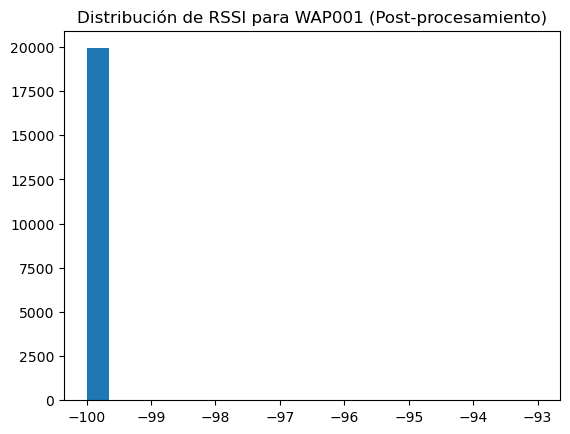

In [4]:
# Reemplazar el valor 100 (señal no detectada) por -100 (señal muy débil)
X = X.replace(100, -100)

print("Reemplazo completado.")
print("Nuevo rango de valores en X:")
print(f"Min: {X.min().min()}, Max: {X.max().max()}")

# Visualización rápida de la distribución de una señal
plt.hist(X.iloc[:, 0], bins=20)
plt.title("Distribución de RSSI para WAP001 (Post-procesamiento)")
plt.show()

---

## Paso 4: Preparación del dataset

**Objetivo:**

Diseñar una función que cargue el dataset **UJIIndoorLoc**, realice limpieza básica si es necesario, normalice las variables predictoras, y divida los datos en tres subconjuntos de forma estratificada para su uso en redes neuronales.

**Esquema de partición:**

1. **20% del dataset se reserva como conjunto de testeo final.**
2. **El 80% restante se subdivide en:**
   - **80% para entrenamiento** → equivale al 64% del total.
   - **20% para validación** → equivale al 16% del total.

  En este caso, ya existe un conjunto de testeo definido por separado. Por lo tanto, la función solo debe dividir el dataset de entrenamiento original en dos subconjuntos estratificados:

  - **80% para entrenamiento**
  - **20% para validación**

**Requisitos de la función:**

- La función debe realizar las siguientes tareas:
  1. Cargar el archivo `.csv` del dataset.
  2. Seleccionar las columnas de entrada (features) y la variable objetivo (`FLOOR`).
  3. Aplicar normalización a las variables predictoras utilizando `MinMaxScaler` para que todos los valores queden entre 0 y 1.
  4. Realizar las divisiones del conjunto de datos en el orden indicado, asegurando estratificación según la variable objetivo.
  
- La función debe recibir como parámetros:
  - La ruta al archivo `.csv` del dataset.
  - El nombre de la columna objetivo (por ejemplo, `FLOOR`).
  - Un parámetro `random_state` para asegurar reproducibilidad de las divisiones.

- La función debe retornar:
  - `X_train`, `X_val`, `X_test`: subconjuntos de características normalizadas.
  - `y_train`, `y_val`, `y_test`: subconjuntos de etiquetas, codificadas si es necesario para clasificación multiclase.

**Nota:** Esta función es fundamental para garantizar un flujo de entrenamiento robusto y reproducible en redes neuronales.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preparar_dataset(path_train, path_test, target_col='FLOOR', random_state=42):
    """
    Carga, limpia, divide y normaliza el dataset UJIIndoorLoc.
    """
    # 1. Cargar datasets
    df_train_full = pd.read_csv(path_train)
    df_test_final = pd.read_csv(path_test)
    
    # 2. Selección de Features (WAP*) y Target
    wap_cols = [c for c in df_train_full.columns if c.startswith('WAP')]
    
    X_full = df_train_full[wap_cols].replace(100, -100)
    y_full = df_train_full[target_col]
    
    X_test = df_test_final[wap_cols].replace(100, -100)
    y_test = df_test_final[target_col]
    
    # 3. División Estratificada 80/20 (Train/Validation)
    # El set de Test ya viene separado, así que dividimos el trainingData
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full,
        test_size=0.20,
        random_state=random_state,
        stratify=y_full
    )
    
    # 4. Normalización (MinMax)
    # IMPORTANTE: El scaler se ajusta (fit) SOLO con el conjunto de entrenamiento
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Convertir targets a numpy para evitar problemas de índices luego
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Rutas a los archivos
path_train_file = 'dataset/UJIIndoorLoc/trainingData.csv'
path_test_file = 'dataset/UJIIndoorLoc/validationData.csv'

# Ejecución
X_train, X_val, X_test, y_train, y_val, y_test = preparar_dataset(
    path_train_file, path_test_file, target_col='FLOOR', random_state=42
)

print("Dimensiones finales:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Dimensiones finales:
Train: (15949, 520), Val: (3988, 520), Test: (1111, 520)


---
## Paso 5: Entrenamiento de redes neuronales artificiales (ANN)

**Objetivo:**

Entrenar y comparar el rendimiento de diferentes arquitecturas de redes neuronales totalmente conectadas (**Fully Connected ANN**) utilizando **PyTorch** para predecir el piso (`FLOOR`) en el dataset UJIIndoorLoc. El objetivo es observar el impacto de la profundidad y la expansión/compresión de capas sobre el rendimiento del modelo.

**Entorno y configuración:**

- **Framework:** PyTorch
- **Función de pérdida:** `nn.CrossEntropyLoss()`  
  > Esta función es equivalente a `sparse_categorical_crossentropy`, por lo que **no es necesario one-hot encoding** en las etiquetas.
- **Optimizador:** `torch.optim.Adam`
- **Activación:** `ReLU` en todas las capas ocultas
- **Salida:** `Softmax` (implícito en `CrossEntropyLoss`)
- **Épocas:** 20
- **Batch size: 32**
- **Sin Dropout ni BatchNormalization**


### Arquitecturas a evaluar

1. **Arquitectura 1: Compacta**
   ```text
   Input (520)
   → Linear(128) + ReLU
   → Linear(4)
   ```

2. **Arquitectura 2: Dos capas ocultas**
   ```text
   Input (520)
   → Linear(256) + ReLU
   → Linear(128) + ReLU
   → Linear(4)
   ```

3. **Arquitectura 3: Tres capas ocultas**
   ```text
   Input (520)
   → Linear(256) + ReLU
   → Linear(128) + ReLU
   → Linear(64) + ReLU
   → Linear(4)
   ```

4. **Arquitectura 4: Pirámide profunda**
   ```text
   Input (520)
   → Linear(512) + ReLU
   → Linear(256) + ReLU
   → Linear(128) + ReLU
   → Linear(64)  + ReLU
   → Linear(4)
   ```

5. **Arquitectura 5: Expansiva y luego compresiva**
   ```text
   Input (520)
   → Linear(1024) + ReLU
   → Linear(512)  + ReLU
   → Linear(256)  + ReLU
   → Linear(128)  + ReLU
   → Linear(64)   + ReLU
   → Linear(4)
   ```


### Instrucciones

- Implementa cada arquitectura como una subclase de `nn.Module` en PyTorch.
- Entrena durante **20 épocas**, utilizando el conjunto de entrenamiento (`X_train`, `y_train`) y validación (`X_val`, `y_val`).
- Registra la **pérdida de entrenamiento y validación** por época en un gráfico.
- Grafica la evolución de la pérdida para analizar tendencias de aprendizaje, sobreajuste o subajuste.
- Evalúa el modelo final con el conjunto de test (`X_test`, `y_test`) y reporta:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1-score**

Usando dispositivo: cpu

Entrenando Arquitectura 1 con capas [128]...
Epoch 5/20 - Train Loss: 0.0149 - Val Loss: 0.0198
Epoch 10/20 - Train Loss: 0.0070 - Val Loss: 0.0185
Epoch 15/20 - Train Loss: 0.0053 - Val Loss: 0.0152
Epoch 20/20 - Train Loss: 0.0044 - Val Loss: 0.0183

Entrenando Arquitectura 2 con capas [256, 128]...
Epoch 5/20 - Train Loss: 0.0146 - Val Loss: 0.0208
Epoch 10/20 - Train Loss: 0.0060 - Val Loss: 0.0233
Epoch 15/20 - Train Loss: 0.0054 - Val Loss: 0.0251
Epoch 20/20 - Train Loss: 0.0071 - Val Loss: 0.0248

Entrenando Arquitectura 3 con capas [256, 128, 64]...
Epoch 5/20 - Train Loss: 0.0163 - Val Loss: 0.0308
Epoch 10/20 - Train Loss: 0.0059 - Val Loss: 0.0184
Epoch 15/20 - Train Loss: 0.0043 - Val Loss: 0.0282
Epoch 20/20 - Train Loss: 0.0098 - Val Loss: 0.0373

Entrenando Arquitectura 4 con capas [512, 256, 128, 64]...
Epoch 5/20 - Train Loss: 0.0195 - Val Loss: 0.0443
Epoch 10/20 - Train Loss: 0.0204 - Val Loss: 0.0208
Epoch 15/20 - Train Loss: 0.0119 - Val L

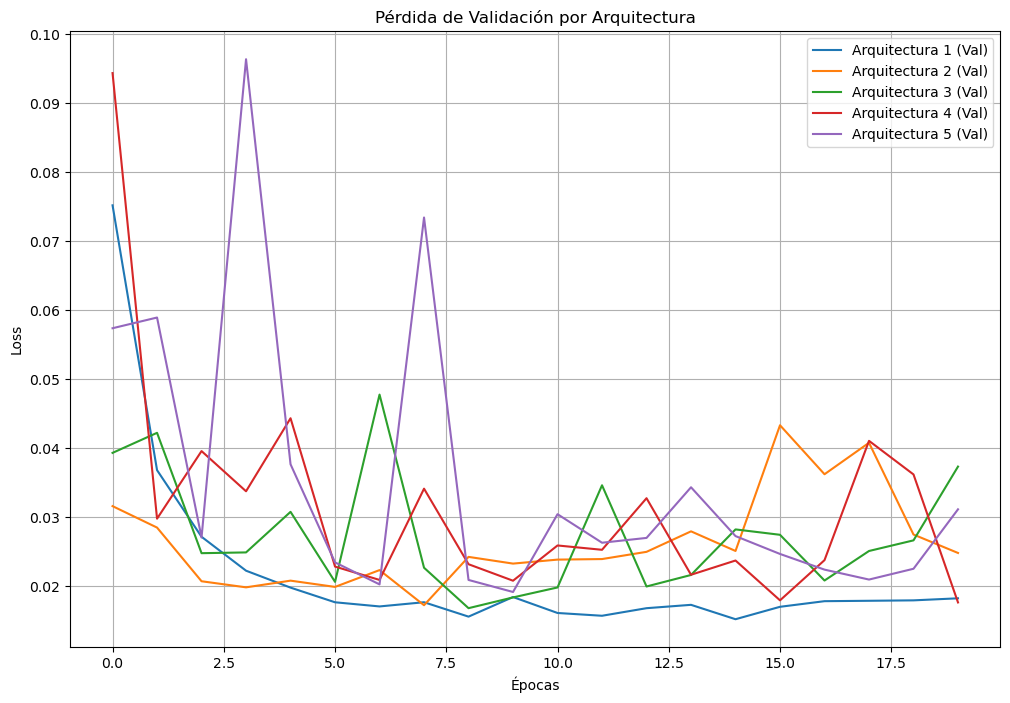

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- 1. Preparar Dataloaders de PyTorch ---
batch_size = 32

# Convertir numpy arrays a tensores
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 2. Definición de Arquitecturas ---

class IndoorModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(IndoorModel, self).__init__()
        layers = []
        in_channels = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(in_channels, hidden_dim))
            layers.append(nn.ReLU())
            in_channels = hidden_dim
            
        layers.append(nn.Linear(in_channels, output_dim))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Definir configuraciones de capas ocultas según instrucciones
architectures_config = {
    "Arquitectura 1": [128],
    "Arquitectura 2": [256, 128],
    "Arquitectura 3": [256, 128, 64],
    "Arquitectura 4": [512, 256, 128, 64],
    "Arquitectura 5": [1024, 512, 256, 128, 64]
}

# --- 3. Funciones de Entrenamiento y Evaluación ---

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Print progress (opcional cada 5 épocas)
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
            
    total_time = time.time() - start_time
    return train_losses, val_losses, total_time

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return acc, prec, rec, f1

# --- 4. Bucle Principal de Experimentación ---

results_list = []
input_dim = 520
output_dim = 5 # Asumiendo pisos 0-4

plt.figure(figsize=(12, 8))

for name, hidden_layers in architectures_config.items():
    print(f"\nEntrenando {name} con capas {hidden_layers}...")
    
    model = IndoorModel(input_dim, hidden_layers, output_dim).to(device)
    train_loss, val_loss, train_time = train_model(model, train_loader, val_loader, epochs=20)
    
    # Evaluar en Test
    acc, prec, rec, f1 = evaluate_model(model, test_loader)
    
    # Guardar resultados
    results_list.append({
        "Arquitectura": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Tiempo de entrenamiento (s)": train_time
    })
    
    # Graficar pérdida
    plt.plot(val_loss, label=f'{name} (Val)')

plt.title('Pérdida de Validación por Arquitectura')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

---

## Paso 6: Tabla resumen de resultados por arquitectura

**Instrucciones:**

Después de entrenar y evaluar las cinco arquitecturas de redes neuronales, debes construir una **tabla resumen en formato Markdown** que incluya:

- El nombre o número de cada arquitectura.
- Las métricas obtenidas sobre el conjunto de **testeo**:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1-score**
- El **tiempo total de entrenamiento** de cada modelo (en segundos).

### Formato de la tabla:

| Arquitectura           | Accuracy | Precision | Recall | F1-score | Tiempo de entrenamiento (s) |
|------------------------|----------|-----------|--------|----------|------------------------------|
| Arquitectura 1         | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| Arquitectura 2         | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| Arquitectura 3         | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| Arquitectura 4         | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| Arquitectura 5         | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |


**Nota:** Puedes medir el tiempo con `time.time()` al inicio y final del entrenamiento de cada modelo.

---


In [8]:
# Crear DataFrame con los resultados
df_results = pd.DataFrame(results_list)

# Mostrar la tabla en formato markdown para copiar y pegar si es necesario, o visualización directa
print(df_results.to_markdown(index=False, floatfmt=".3f"))

# Visualización más limpia en Jupyter
display(df_results)

| Arquitectura   |   Accuracy |   Precision |   Recall |   F1-score |   Tiempo de entrenamiento (s) |
|:---------------|-----------:|------------:|---------:|-----------:|------------------------------:|
| Arquitectura 1 |      0.886 |       0.889 |    0.886 |      0.886 |                        30.171 |
| Arquitectura 2 |      0.831 |       0.856 |    0.831 |      0.833 |                        46.682 |
| Arquitectura 3 |      0.882 |       0.882 |    0.882 |      0.880 |                        52.343 |
| Arquitectura 4 |      0.834 |       0.849 |    0.834 |      0.836 |                        86.342 |
| Arquitectura 5 |      0.833 |       0.848 |    0.833 |      0.834 |                       176.772 |


,Arquitectura,Accuracy,Precision,Recall,F1-score,Tiempo de entrenamiento (s)
0,Arquitectura 1,0.885689,0.889151,0.885689,0.886013,30.171330
1,Arquitectura 2,0.830783,0.856456,0.830783,0.832942,46.681825
2,Arquitectura 3,0.882088,0.882408,0.882088,0.880297,52.342754
3,Arquitectura 4,0.834383,0.848936,0.834383,0.835885,86.341557
4,Arquitectura 5,0.833483,0.848437,0.833483,0.834178,176.771806


| Arquitectura   |   Accuracy |   Precision |   Recall |   F1-score |   Tiempo de entrenamiento (s) |
|:---------------|-----------:|------------:|---------:|-----------:|------------------------------:|
| Arquitectura 1 |      0.886 |       0.889 |    0.886 |      0.886 |                        30.171 |
| Arquitectura 2 |      0.831 |       0.856 |    0.831 |      0.833 |                        46.682 |
| Arquitectura 3 |      0.882 |       0.882 |    0.882 |      0.880 |                        52.343 |
| Arquitectura 4 |      0.834 |       0.849 |    0.834 |      0.836 |                        86.342 |
| Arquitectura 5 |      0.833 |       0.848 |    0.833 |      0.834 |                       176.772 |

---

## Paso 7: Evaluar el impacto del número de épocas en el mejor modelo

**Objetivo:**

Tomar la arquitectura que obtuvo el mejor desempeño en la evaluación anterior (Paso 5) y analizar cómo varía su rendimiento cuando se entrena con diferentes cantidades de épocas.

**Instrucciones:**

1. Selecciona la arquitectura con mejor desempeño global (según F1-score).
2. Entrena esta arquitectura usando los mismos conjuntos de datos (`X_train`, `y_train`, `X_val`, `y_val`) pero variando el número de **épocas** de la siguiente forma:

   - 10 épocas
   - 20 épocas
   - 30 épocas
   - 40 épocas
   - 50 épocas

3. Para cada configuración:
   - Registra el **tiempo de entrenamiento**.
   - Evalúa el modelo en el conjunto de **testeo** (`X_test`, `y_test`).
   - Reporta las métricas:
     - Accuracy
     - Precision
     - Recall
     - F1-score

4. Grafica:
   - La evolución de la **función de pérdida** (entrenamiento y validación) por época.
---


Mejor arquitectura seleccionada: Arquitectura 1 [128]
Entrenando modelo de referencia para gráfica de Loss (50 épocas)...
Epoch 5/50 - Train Loss: 0.0145 - Val Loss: 0.0203
Epoch 10/50 - Train Loss: 0.0069 - Val Loss: 0.0173
Epoch 15/50 - Train Loss: 0.0051 - Val Loss: 0.0196
Epoch 20/50 - Train Loss: 0.0042 - Val Loss: 0.0181
Epoch 25/50 - Train Loss: 0.0041 - Val Loss: 0.0218
Epoch 30/50 - Train Loss: 0.0041 - Val Loss: 0.0238
Epoch 35/50 - Train Loss: 0.0045 - Val Loss: 0.0236
Epoch 40/50 - Train Loss: 0.0036 - Val Loss: 0.0246
Epoch 45/50 - Train Loss: 0.0038 - Val Loss: 0.0247
Epoch 50/50 - Train Loss: 0.0034 - Val Loss: 0.0295


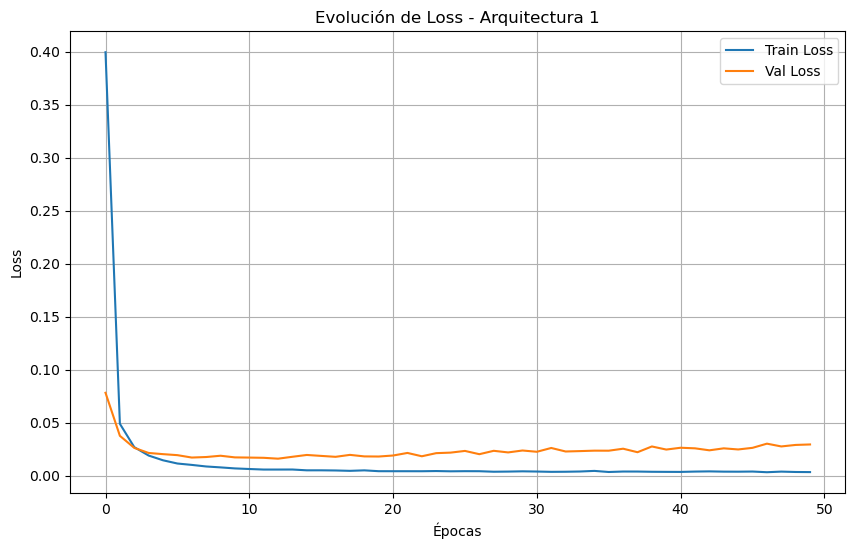


Comenzando evaluación por épocas...
Entrenando por 10 épocas...
Epoch 5/10 - Train Loss: 0.0149 - Val Loss: 0.0197
Epoch 10/10 - Train Loss: 0.0073 - Val Loss: 0.0158
Entrenando por 20 épocas...
Epoch 5/20 - Train Loss: 0.0145 - Val Loss: 0.0190
Epoch 10/20 - Train Loss: 0.0066 - Val Loss: 0.0159
Epoch 15/20 - Train Loss: 0.0049 - Val Loss: 0.0167
Epoch 20/20 - Train Loss: 0.0046 - Val Loss: 0.0176
Entrenando por 30 épocas...
Epoch 5/30 - Train Loss: 0.0143 - Val Loss: 0.0191
Epoch 10/30 - Train Loss: 0.0073 - Val Loss: 0.0163
Epoch 15/30 - Train Loss: 0.0053 - Val Loss: 0.0172
Epoch 20/30 - Train Loss: 0.0044 - Val Loss: 0.0194
Epoch 25/30 - Train Loss: 0.0042 - Val Loss: 0.0215
Epoch 30/30 - Train Loss: 0.0038 - Val Loss: 0.0204
Entrenando por 40 épocas...
Epoch 5/40 - Train Loss: 0.0146 - Val Loss: 0.0198
Epoch 10/40 - Train Loss: 0.0072 - Val Loss: 0.0167
Epoch 15/40 - Train Loss: 0.0055 - Val Loss: 0.0170
Epoch 20/40 - Train Loss: 0.0044 - Val Loss: 0.0185
Epoch 25/40 - Train Los

In [9]:
# 1. Identificar mejor modelo
best_arch_name = df_results.loc[df_results['F1-score'].idxmax()]['Arquitectura']
best_hidden_layers = architectures_config[best_arch_name]
print(f"Mejor arquitectura seleccionada: {best_arch_name} {best_hidden_layers}")

# 2. Configuración de épocas
epochs_list = [10, 20, 30, 40, 50]
epoch_results = []

plt.figure(figsize=(10, 6))


model_long = IndoorModel(input_dim, best_hidden_layers, output_dim).to(device)

# Entrenar modelo largo para graficar la loss completa
print("Entrenando modelo de referencia para gráfica de Loss (50 épocas)...")
train_l, val_l, _ = train_model(model_long, train_loader, val_loader, epochs=50)
plt.plot(train_l, label='Train Loss')
plt.plot(val_l, label='Val Loss')
plt.title(f'Evolución de Loss - {best_arch_name}')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Entrenamientos independientes para la tabla
print("\nComenzando evaluación por épocas...")
for eps in epochs_list:
    print(f"Entrenando por {eps} épocas...")
    model = IndoorModel(input_dim, best_hidden_layers, output_dim).to(device)
    _, _, time_taken = train_model(model, train_loader, val_loader, epochs=eps)
    
    acc, prec, rec, f1 = evaluate_model(model, test_loader)
    
    epoch_results.append({
        "Épocas": eps,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Tiempo de entrenamiento (s)": time_taken
    })


---

## Paso 8: Tabla resumen de resultados por número de épocas

**Objetivo:**

Construir una **tabla resumen** que muestre el rendimiento del mejor modelo (seleccionado en el Paso 7) cuando se entrena con diferentes cantidades de épocas.

**Instrucciones:**

- Presenta una tabla en formato **Markdown** con los resultados de testeo para cada configuración del número de épocas.
- La tabla debe incluir las siguientes columnas:
  - Número de épocas
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - Tiempo de entrenamiento (en segundos)

### Formato de la tabla:

| Épocas | Accuracy | Precision | Recall | F1-score | Tiempo de entrenamiento (s) |
|--------|----------|-----------|--------|----------|------------------------------|
| 10     | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| 20     | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| 30     | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| 40     | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |
| 50     | 0.XXX    | 0.XXX     | 0.XXX  | 0.XXX    | XXX                          |

> Reemplaza los valores con los resultados reales obtenidos. Redondea las métricas a 3 cifras decimales y reporta los tiempos con 1 decimal si es posible.


In [10]:
# Crear DataFrame de resultados por épocas
df_epochs = pd.DataFrame(epoch_results)

# Mostrar tabla Markdown
print(df_epochs.to_markdown(index=False, floatfmt=".3f"))

# Visualización
display(df_epochs)

|   Épocas |   Accuracy |   Precision |   Recall |   F1-score |   Tiempo de entrenamiento (s) |
|---------:|-----------:|------------:|---------:|-----------:|------------------------------:|
|   10.000 |      0.885 |       0.893 |    0.885 |      0.886 |                        15.069 |
|   20.000 |      0.889 |       0.897 |    0.889 |      0.890 |                        30.143 |
|   30.000 |      0.869 |       0.882 |    0.869 |      0.870 |                        45.980 |
|   40.000 |      0.877 |       0.883 |    0.877 |      0.877 |                        59.302 |
|   50.000 |      0.869 |       0.871 |    0.869 |      0.870 |                        74.167 |


,Épocas,Accuracy,Precision,Recall,F1-score,Tiempo de entrenamiento (s)
0,10,0.884788,0.893200,0.884788,0.885624,15.068659
1,20,0.889289,0.897007,0.889289,0.889877,30.142757
2,30,0.869487,0.881958,0.869487,0.870353,45.979769
3,40,0.876688,0.883030,0.876688,0.877218,59.302462
4,50,0.869487,0.871173,0.869487,0.869543,74.167017


|   Épocas |   Accuracy |   Precision |   Recall |   F1-score |   Tiempo de entrenamiento (s) |
|---------:|-----------:|------------:|---------:|-----------:|------------------------------:|
|   10.000 |      0.885 |       0.893 |    0.885 |      0.886 |                        15.069 |
|   20.000 |      0.889 |       0.897 |    0.889 |      0.890 |                        30.143 |
|   30.000 |      0.869 |       0.882 |    0.869 |      0.870 |                        45.980 |
|   40.000 |      0.877 |       0.883 |    0.877 |      0.877 |                        59.302 |
|   50.000 |      0.869 |       0.871 |    0.869 |      0.870 |                        74.167 |

---

## Preguntas de análisis

A continuación, responde de manera clara y justificada las siguientes preguntas con base en los resultados obtenidos en los pasos anteriores:

1. **¿Cuál considera que fue la mejor arquitectura evaluada? ¿Por qué?**
2. **¿Cuál fue la arquitectura con peor desempeño? ¿A qué cree que se debió su bajo rendimiento?**
3. **¿Cómo influye el número de capas ocultas en el comportamiento de la red?**
4. **¿Cuál fue la mejor cantidad de épocas para entrenar el mejor modelo? Justifique su elección.**
5. **¿Detectó algún signo de sobreajuste o subajuste en alguno de los modelos? ¿Cómo lo identificó?**
6. **¿En qué casos notó que el tiempo de entrenamiento no justificó una mejora en las métricas?**
7. **¿La arquitectura más profunda fue también la más precisa? ¿Qué conclusiones saca de esto?**
8. **¿Qué métrica considera más importante en este contexto (accuracy, precision, recall, F1-score) y por qué?**


---

## Rúbrica de evaluación del proyecto

El proyecto se compone de nueve pasos estructurados. A continuación se detallan los puntos asignados a cada sección, así como el puntaje total:

| Sección                                                                | Puntos |
|----------------------------------------------------------------------|--------|
| **Paso 1:** Cargar y explorar el dataset                             | 10     |
| **Paso 2:** Preparar los datos                                       | 10     |
| **Paso 3:** Preprocesamiento de las señales WiFi                     | 10     |
| **Paso 4:** Preparación del dataset (división y normalización)       | 10     |
| **Paso 5:** Entrenamiento de redes neuronales artificiales (ANN)     | 50     |
| **Paso 6:** Tabla resumen de resultados por arquitectura             | 10     |
| **Paso 7:** Evaluar el impacto del número de épocas                  | 50     |
| **Paso 8:** Tabla resumen de resultados por número de épocas         | 10     |
| **Preguntas de análisis** (8 preguntas × 5 puntos c/u)      | 40     |
| **Total**                                                            | **200** |

---

**Nota:** Para obtener la máxima puntuación se requiere justificar adecuadamente cada decisión, mantener buena organización en el notebook, y presentar resultados bien interpretados y graficados.

---

